# Snowflake images 
We can now display a few actual images of the snowflakes in the database, to show how they appear. 

In [1]:
# Imports
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches

mpl.rcParams.update({'font.size': 12,
    "legend.frameon": False,
    "font.family": "sans-serif",
    "mathtext.default": "regular"})
mpl.rcParams['figure.dpi'] = 400

# Scikit image
from skimage import filters, measure, morphology

# MASC DB
from mascdb.api import MASC_DB
from mascdb.utils_img import _hist_equalization, _local_hist_equalization, _contrast_stretching  

dir_path = "/data/MASC_DB" #It must contains the 4 parquet files and the Zarr storage

# Create MASC_DB instance
mascdb = MASC_DB(dir_path=dir_path)

## Image descriptors visualization
Let's now compute and/or visualize some image descriptors using *skimage* on raw gray-scale images in combination with precooked attributes available in the tabular database. 

We are now just scraping the surface. There are many ways to display or manipulate the images. There is however a functionality that is worth to mention, which is *mascdb.api.MASC_DB.compute_2d_image_descriptors*. The interested users should have a look at it as it allows to compute new descriptors and to include them in the database.

In [2]:
# Select only high quality images in CAM1 (as example)
idx = mascdb.cam1['quality_xhi'] > 9.5
mascdb = mascdb.isel(idx) 

# Arrange the database with large Dmax first and choose one image
mascdb = mascdb.arrange('cam1.Dmax', decreasing=True)
img = mascdb.da.isel(cam_id=1, flake_id=1).values

/home/grazioli/anaconda3/envs/mascdb/lib/python3.8/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing with an out-of-order index is generating 83 times more chunks
  return self.array[key]


(-0.5, 1023.5, 1023.5, -0.5)

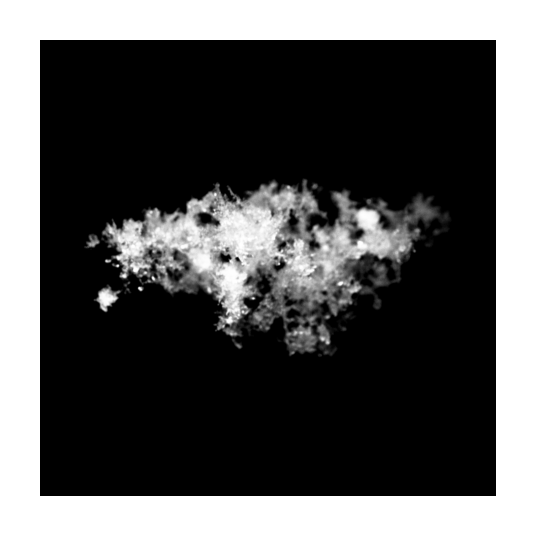

In [3]:
# Get image
plt.figure(figsize=(1.5,1.5), tight_layout=True)
plt.imshow(_hist_equalization(img),cmap='gray')
plt.axis('off')

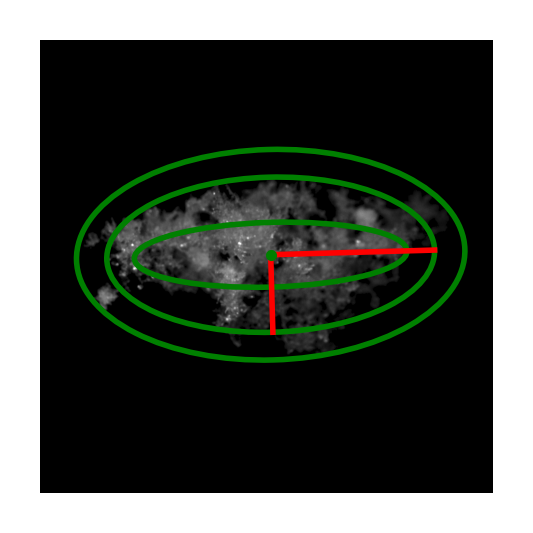

In [4]:
# Retrieve some standard image properties 
# Obtain a binary image
binary_mask = img > 0

# Background is label 0 
labels = measure.label(binary_mask)

# Remove spurious stuffs 
labels[labels != 1] = 0  

# compute properties of regions    
region_props = measure.regionprops(labels)

# Plot minor and major axis of the ellipse, the centroid 
fig, ax = plt.subplots(figsize=(1.5,1.5))
ax.imshow(img, cmap=plt.cm.gray)

# Flake id and resolution
flake_id = 1 # as in previous block
res      = mascdb.cam1.iloc[flake_id].pix_size

# Plot fitted, internal and external ellipse
for props in region_props:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    # Plot orientation
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=1)
    ax.plot(x0, y0, '.g', markersize=2)
    
    # Plot ellipse(s)
    e1 = patches.Ellipse((x0,y0),
        props.minor_axis_length,props.major_axis_length,linewidth=1,
        fill=False,angle=-1*np.rad2deg(props.orientation),color='g')
    ax.add_patch(e1)     
    
    e1 = patches.Ellipse((x0,y0),
       2*mascdb.cam1.iloc[flake_id].ell_out_B/res,2*mascdb.cam1.iloc[flake_id].ell_out_A/res,linewidth=1,
        fill=False,angle=-1*np.rad2deg(props.orientation),color='g')
    ax.add_patch(e1)
    
    e1 = patches.Ellipse((x0,y0),
       2*mascdb.cam1.iloc[flake_id].ell_in_B/res,2*mascdb.cam1.iloc[flake_id].ell_in_A/res,linewidth=1,
        fill=False,angle=-1*np.rad2deg(props.orientation),color='g')
    ax.add_patch(e1)
    
   
plt.axis('off')
plt.show()


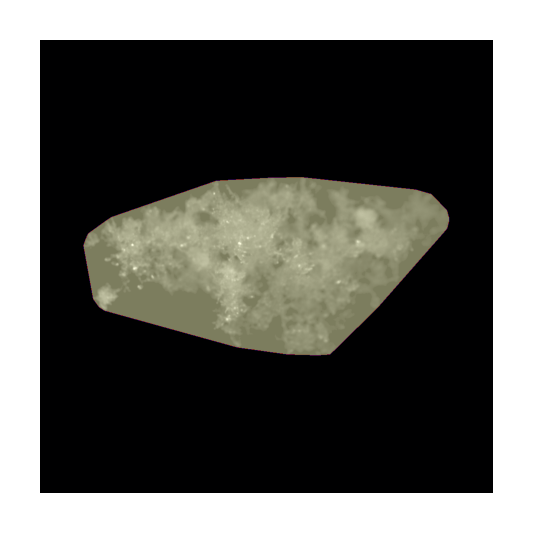

In [5]:
# Overlay the convex hull mask
fig, ax = plt.subplots(figsize=(1.5,1.5))
ax.imshow(img, cmap=plt.cm.gray)

for props in region_props:
    
    
   # Overlay an image
   img_overlay= labels*0
 
   img_overlay[props.bbox[0]:props.bbox[2],props.bbox[1]:props.bbox[3]] = props.convex_image*255
   ax.imshow(img_overlay,cmap='magma',alpha=0.5)    
   
plt.axis('off')    
plt.show()

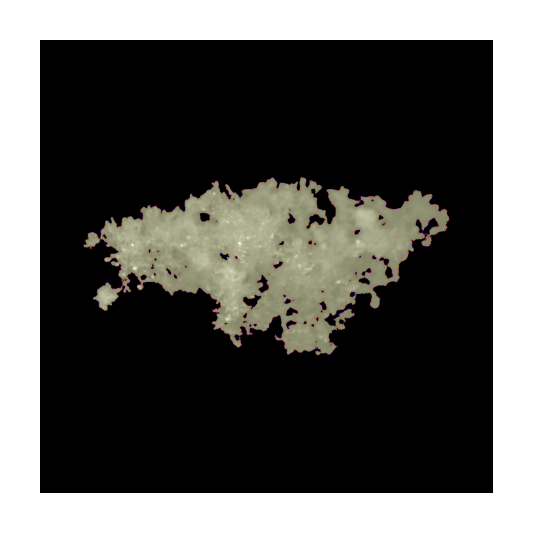

In [6]:
# Overlay a binary mask with internal holes
fig, ax = plt.subplots(figsize=(1.5,1.5))
ax.imshow(img, cmap=plt.cm.gray)

for props in region_props:
    
    
   # Overlay an image
   img_overlay= labels*0
 
   img_overlay[props.bbox[0]:props.bbox[2],props.bbox[1]:props.bbox[3]] = props.image*255
   ax.imshow(img_overlay,cmap='magma',alpha=0.5)    
   
plt.axis('off')    
plt.show()